# Machine Learning project a.y. 2021/2022

## Scikit-learn MLPRegressor model

## Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

## Loading training set and blind test set

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]

## Loading MONK dataset 

In [ ]:
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


In [ ]:
target_train = df_monk1_train[['class']]
df_monk1_train.drop(labels='class', axis=1, inplace=True)
target_test = df_monk1_test[['class']]
df_monk1_test.drop(labels='class', axis=1, inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(df_monk1_train, target, stratify = target, test_size = 0.30, random_state = 42)
X_train = df_monk1_train
y_train = target_train
X_test = df_monk1_test
y_test = target_test

In [ ]:
y_train = y_train.values #returns a ndarray 
X_train = X_train.values #returns a ndarray
y_test = y_test.values
X_test = X_test.values
y_train = y_train.ravel() #flattens the array into a 1-dimensional array
y_test = y_test.ravel() #flattens the array into a 1-dimensional array

### One hot encoding 
In the MONK dataset we have the categories encoded using label encoding, we need to use one hot encoding in order to have better results. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc_train = OneHotEncoder()
enc_train.fit(X_train)
X_train = enc_train.transform(X_train).toarray()
print(X_train.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test)
X_test = enc_test.transform(X_test).toarray()
print(X_test.shape)

(124, 17)
(432, 17)


In [ ]:
regressor = MLPRegressor(random_state=42, batch_size=1, max_iter=1000).fit(X_train, y_train)

In [ ]:
regressor.score(X_test, y_test)

0.9407379353401937

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/pyplot.py'>

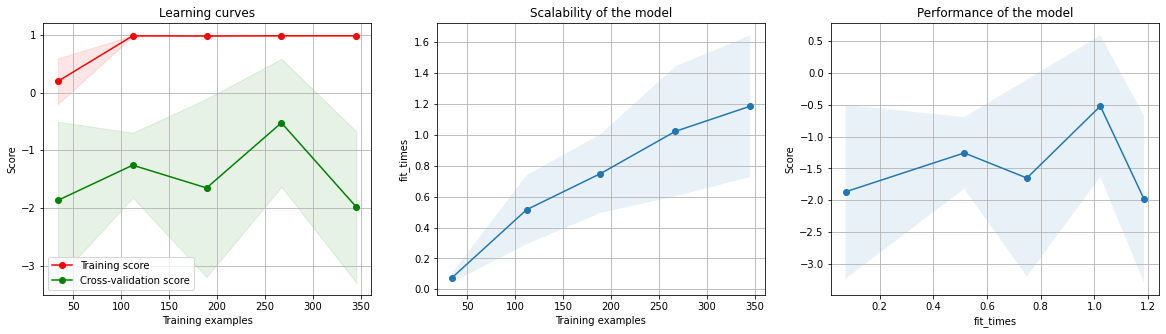

In [ ]:
title = "Learning curves"

plot_learning_curve(regressor,title, X_test, y_test)

In [ ]:
#in order to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"hidden_layer_sizes": [(3,), (5,), (10,),(100,), (50,), ],
              "activation": ['identity', 'logistic', 'tanh', 'relu'],
              "solver": ['lbfgs', 'sgd', 'adam'],
              "learning_rate": ['constant', 'adaptive'],
              "learning_rate_init": uniform(0.01,0.5),
              "alpha": uniform(0.0001, 0.01),
              "batch_size": randint(1,X_train.shape[0]),
              "n_iter_no_change": [10, 25, 50],
             }
#define the number of iterations
n_iter_search = 100
#define the model
regressor = MLPRegressor()
#define the grid search
grid_search = RandomizedSearchCV(regressor, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(X_train, y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


RandomizedSearchCV(estimator=MLPRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff3b874b6d0>,
                                        'batch_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff3b874b810>,
                                        'hidden_layer_sizes': [(3,), (5,),
                                                               (10,), (100,),
                                                               (50,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff3b8759990>,
                                   

In [ ]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])

Best setting parameters  {'activation': 'relu', 'alpha': 0.0014822389811434133, 'batch_size': 17, 'hidden_layer_sizes': (3,), 'learning_rate': 'constant', 'learning_rate_init': 0.0630141512036249, 'solver': 'adam'}


In [ ]:
gs_regressor = MLPRegressor(random_state=42, activation = 'relu', alpha = 0.0014822389811434133, batch_size = 65, hidden_layer_sizes = (3,), learning_rate = 'constant', learning_rate_init = 0.0630141512036249,  solver='adam', max_iter = 1000).fit(X_train, y_train)

In [ ]:
gs_regressor.score(X_test, y_test)

0.7786714847587235

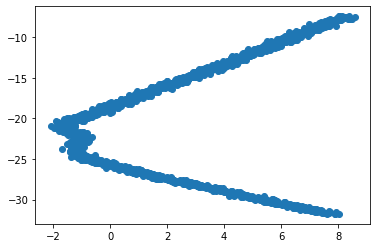

In [ ]:
plt.scatter(df_visual['x'], df_visual['y'])

In [ ]:
label = df[['x','y']]
df.drop(labels=['x','y'], axis=1, inplace=True)
#train_set, test_set, train_label, test_label = train_test_split(adult, label, stratify =label, test_size=0.30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, label, random_state=42, test_size=0.30)

In [ ]:
regressor = MLPRegressor(random_state=42, max_iter=500).fit(X_train, y_train)

In [ ]:
regressor.score(X_test, y_test)

0.8696963705237135

In [ ]:
y_pred = regressor.predict(df_blind_ts)

In [ ]:
y_pred = pd.DataFrame(data=y_pred, columns=["x", "y"])

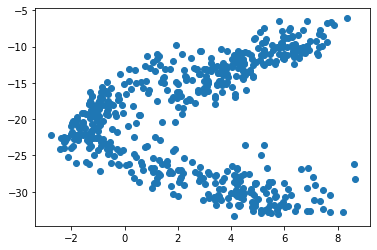

In [ ]:
plt.scatter(y_pred['x'], y_pred['y'])

## Grid Search

In [ ]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"hidden_layer_sizes": [(100,), (50,), (100, 100), (50,50)],
              "activation": ['identity', 'logistic', 'tanh', 'relu'],
              "solver": ['lbfgs', 'sgd', 'adam'],
              "max_iter": [1000],
             }
#define the number of iterations
n_iter_search = 5
#define the model
regressor = MLPRegressor()
#define the grid search
grid_search = RandomizedSearchCV(regressor, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(X_train, y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RandomizedSearchCV(estimator=MLPRegressor(), n_iter=5, n_jobs=10,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(100,), (50,),
                                                               (100, 100),
                                                               (50, 50)],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring=make_scorer(accuracy_score))

In [ ]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])

Best setting parameters  {'solver': 'lbfgs', 'max_iter': 1000, 'hidden_layer_sizes': (50, 50), 'activation': 'tanh'}


In [ ]:
gs_regressor = MLPRegressor(solver='adam', max_iter = 1000, hidden_layer_sizes = (100, 100), activation = 'tanh').fit(X_train, y_train)

In [ ]:
gs_regressor.score(X_test, y_test)

0.908432158442845

In [ ]:
y_pred = gs_regressor.predict(df_blind_ts)

In [ ]:
y_pred = pd.DataFrame(data=y_pred, columns=["x", "y"])

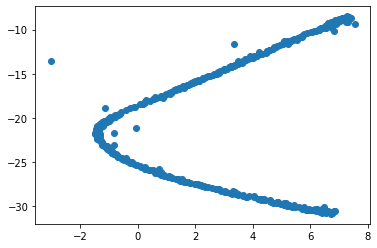

In [ ]:
plt.scatter(y_pred['x'], y_pred['y'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>